In [140]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import curve_fit
import warnings
import requests

from helper.option_helpers import (
    filter_expir_dates_per_ticker,
    calculate_forward_volatility,
    plot_iv_vol_by_strike,
    get_nearest_strikes_per_ticker,
    calculate_weighted_average_columns_per_ticker,
    plot_histogram,
    plot_histogram_interactive,
    create_plot_interface,
    plot_column_by_expir_date,
    create_interactive_ticker_plot,
    nelson_siegel_fit,
    compare_vols_plot,
    filter_df_by_matching_tickers,
    calculate_forward_volatility_shifted_with_expir,
    plot_volatilities
)

In [105]:
options_url = "https://api.orats.io/datav2/hist/strikes"
cores_url = "https://api.orats.io/datav2/hist/cores"
earns_url = "https://api.orats.io/datav2/hist/earnings"

token = "df44ef7f-80ab-4508-924c-0e6d199723fc"
tickers = pd.read_csv("data/tickers.csv")[["Symbol", "Weight"]]
pd.set_option('display.max_columns', None)
trade_date = "2025-05-28"


request_list = []

for i in range(0, 50):
    request_list += [list(tickers.Symbol[(i * 10):(i * 10 + 10)])]
    
top_150 = request_list[0:15]
querystrings = []
for check in top_150:
    querystring = {"token":token, "ticker": ",".join(check), "tradeDate":trade_date}
    querystrings += [querystring]
    
df_list = []
# for qs in querystrings:
#     response = requests.request("GET", earns_url, params=qs)
#     df = pd.json_normalize(response.json()["data"])
#     df['earnDate'] = pd.to_datetime(df['earnDate'])
#     df['earnDateShifted'] = df['earnDate']  + pd.offsets.BusinessDay(1)
#     df['anncTod'] = df['anncTod'].astype(int)
#     df['earnDateEff'] = np.where(df['anncTod'] > 1600, df['earnDateShifted'], df['earnDate'])
#     df_list += [df]

for qs in querystrings:
    response = requests.request("GET", cores_url, params=qs)
    df = pd.json_normalize(response.json()["data"])
    df_list += [df]

all_earnings_df = pd.concat(df_list)


In [106]:
import yfinance as yf
import pandas as pd

top_150_erns_tickers = tickers.Symbol[0:150]

earnings_data = []

for ticker_symbol in top_150_erns_tickers:
    try:
        ticker = yf.Ticker(ticker_symbol)
        earnings_calendar = ticker.calendar
        if earnings_calendar is not None:
            earnings_date = earnings_calendar["Earnings Date"][0]  # First earnings date
            earnings_data.append({'ticker': ticker_symbol, 'earnDate': earnings_date})
    except Exception as e:
        print(f"Could not fetch earnings for {ticker_symbol}: {e}")
        earnings_data.append({'ticker': ticker_symbol, 'earnDate': None})

earnings_df = pd.DataFrame(earnings_data)

In [107]:
all_earnings_df.tail()

,ticker,tradeDate,assetType,priorCls,pxAtmIv,mktCap,cVolu,cOi,pVolu,pOi,orFcst20d,orIvFcst20d,orFcstInf,orIvXern20d,orIvXernInf,iv200Ma,atmIvM1,atmFitIvM1,atmFcstIvM1,dtExM1,atmIvM2,atmFitIvM2,atmFcstIvM2,dtExM2,atmIvM3,atmFitIvM3,atmFcstIvM3,dtExM3,atmIvM4,atmFitIvM4,atmFcstIvM4,dtExM4,iRate5wk,iRateLt,px1kGam,volOfVol,volOfIvol,slope,slopeInf,slopeFcst,slopeFcstInf,deriv,derivInf,derivFcst,derivFcstInf,mktWidthVol,mktWidthVolInf,cAddPrem,pAddPrem,rip,ivEarnReturn,fcstR2,fcstR2Imp,hiHedge,loHedge,stkVolu,avgOptVolu20d,sector,orHv1d,orHv5d,orHv10d,orHv20d,orHv60d,orHv90d,orHv120d,orHv252d,orHv500d,orHv1000d,clsHv5d,clsHv10d,clsHv20d,clsHv60d,clsHv90d,clsHv120d,clsHv252d,clsHv500d,clsHv1000d,iv20d,iv30d,iv60d,iv90d,iv6m,clsPx1w,stkPxChng1wk,clsPx1m,stkPxChng1m,clsPx6m,stkPxChng6m,clsPx1y,stkPxChng1y,divFreq,divYield,divGrwth,divDate,divAmt,nextErn,nextErnTod,lastErn,lastErnTod,absAvgErnMv,impliedIee,daysToNextErn,tkOver,etfIncl,bestEtf,sectorName,correlSpy1m,correlSpy1y,correlEtf1m,correlEtf1y,beta1m,beta1y,ivPctile1m,ivPctile1y,ivPctileSpy,ivPctileEtf,ivStdvMean,ivStdv1y,ivSpyRatio,ivSpyRatioAvg1m,ivSpyRatioAvg1y,ivSpyRatioStdv1y,ivEtfRatio,ivEtfRatioAvg1m,ivEtfRatioAvg1y,ivEtFratioStdv1y,ivHvXernRatio,ivHvXernRatio1m,ivHvXernRatio1y,ivHvXernRatioStdv1y,etfIvHvXernRatio,etfIvHvXernRatio1m,etfIvHvXernRatio1y,etfIvHvXernRatioStdv1y,slopepctile,slopeavg1m,slopeavg1y,slopeStdv1y,etfSlopeRatio,etfSlopeRatioAvg1m,etfSlopeRatioAvg1y,etfSlopeRatioAvgStdv1y,impliedR2,contango,nextDiv,impliedNextDiv,annActDiv,annIdiv,borrow30,borrow2yr,error,confidence,pxCls,wksNextErn,ernMnth,oi,straPxM1,straPxM2,smoothStraPxM1,smoothStrPxM2,fcstStraPxM1,fcstStraPxM2,loStrikeM1,hiStrikeM1,loStrikeM2,hiStrikeM2,ernDate1,ernDate2,ernDate3,ernDate4,ernDate5,ernDate6,ernDate7,ernDate8,ernDate9,ernDate10,ernDate11,ernDate12,ernMv1,ernMv2,ernMv3,ernMv4,ernMv5,ernMv6,ernMv7,ernMv8,ernMv9,ernMv10,ernMv11,ernMv12,ernStraPct1,ernStraPct2,ernStraPct3,ernStraPct4,ernStraPct5,ernStraPct6,ernStraPct7,ernStraPct8,ernStraPct9,ernStraPct10,ernStraPct11,ernStraPct12,ernEffct1,ernEffct2,ernEffct3,ernEffct4,ernEffct5,ernEffct6,ernEffct7,ernEffct8,ernEffct9,ernEffct10,ernEffct11,ernEffct12,orHvXern5d,orHvXern10d,orHvXern20d,orHvXern60d,orHvXern90d,orHvXern120d,orHvXern252d,orHvXern500d,orHvXern1000d,clsHvXern5d,clsHvXern10d,clsHvXern20d,clsHvXern60d,clsHvXern90d,clsHvXern120d,clsHvXern252d,clsHvXern500d,clsHvXern1000d,iv10d,iv1yr,fcstSlope,fcstErnEffct,ernMvStdv,impliedEe,impErnMv,impMth2ErnMv,fairVol90d,fairXieeVol90d,fairMth2XieeVol90d,impErnMv90d,impErnMvMth290d,exErnIv10d,exErnIv20d,exErnIv30d,exErnIv60d,exErnIv90d,exErnIv6m,exErnIv1yr,dlt5Iv10d,dlt5Iv20d,dlt5Iv30d,dlt5Iv60d,dlt5Iv90d,dlt5Iv6m,dlt5Iv1y,exErnDlt5Iv10d,exErnDlt5Iv20d,exErnDlt5Iv30d,exErnDlt5Iv60d,exErnDlt5Iv90d,exErnDlt5Iv6m,exErnDlt5Iv1y,dlt25Iv10d,dlt25Iv20d,dlt25Iv30d,dlt25Iv60d,dlt25Iv90d,dlt25Iv6m,dlt25Iv1y,exErnDlt25Iv10d,exErnDlt25Iv20d,exErnDlt25Iv30d,exErnDlt25Iv60d,exErnDlt25Iv90d,exErnDlt25Iv6m,exErnDlt25Iv1y,dlt75Iv10d,dlt75Iv20d,dlt75Iv30d,dlt75Iv60d,dlt75Iv90d,dlt75Iv6m,dlt75Iv1y,exErnDlt75Iv10d,exErnDlt75Iv20d,exErnDlt75Iv30d,exErnDlt75Iv60d,exErnDlt75Iv90d,exErnDlt75Iv6m,exErnDlt75Iv1y,dlt95Iv10d,dlt95Iv20d,dlt95Iv30d,dlt95Iv60d,dlt95Iv90d,dlt95Iv6m,dlt95Iv1y,exErnDlt95Iv10d,exErnDlt95Iv20d,exErnDlt95Iv30d,exErnDlt95Iv60d,exErnDlt95Iv90d,exErnDlt95Iv6m,exErnDlt95Iv1y,fwd30_20,fwd60_30,fwd90_60,fwd180_90,fwd90_30,fexErn30_20,fexErn60_30,fexErn90_60,fexErn180_90,fexErn90_30,ffwd30_20,ffwd60_30,ffwd90_60,ffwd180_90,ffwd90_30,ffexErn30_20,ffexErn60_30,ffexErn90_60,ffexErn180_90,ffexErn90_30,fbfwd30_20,fbfwd60_30,fbfwd90_60,fbfwd180_90,fbfwd90_30,fbfexErn30_20,fbfexErn60_30,fbfexErn90_60,fbfexErn180_90,fbfexErn90_30,impliedEarningsMove,updatedAt
5,MMM,2025-05-28,3,149.49,148.63,79990,1221,103649,1310,66523,25.0685,22.8028,27.79,25.94,25.73,25.93,25.7589,26.3793,25.3144,24,25.9580,25.9218,26.0051,52,29.2487,29.0356,27.7107,115,28.6145,28.4265,27.6387,143,4.35,4.15,3022.28,0.0616,0.0477,1.97119,

In [108]:
base_df = pd.read_csv("data/Strikes_20250528.csv")

In [109]:
filtered_data = filter_expir_dates_per_ticker(base_df)

filtered_data.head()

,trade_date,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px
0,2025-05-28,A,A250620C00055000,A250620P00055000,111.18,2025-06-20,0.06301,55.0,1,1,0,0,54.4,56.35,58.5,0.0,0.0,0.75,0.0,1.12354,2.247089,0.479357,0.0,0.87236,1.744728,0.0435,0,-0.004456,1.000000,0.000000e+00,-0.000000e+00,0.000010,0.034568,-0.070088,-2.200000e-07,0.489621,56.346024,2.469422e-09,0.0
1,2025-05-28,A,A250620C00060000,A250620P00060000,111.18,2025-06-20,0.06301,60.0,0,0,1,1,49.6,51.36,53.4,0.0,0.0,0.60,0.0,0.99264,1.985276,0.479563,0.0,0.74302,1.486035,0.0435,0,-0.004456,1.000000,2.000000e-08,-1.200000e-07,0.000010,0.037710,-0.070088,-3.100000e-07,0.490062,51.361118,2.320537e-07,0.0
2,2025-05-28,A,A250620C00065000,A250620P00065000,111.18,2025-06-20,0.06301,65.0,0,0,0,0,44.6,46.38,48.4,0.0,0.0,0.75,0.0,0.88639,1.772787,0.475686,0.0,0.69103,1.382051,0.0435,0,-0.004456,0.999998,5.600000e-07,-4.260000e-06,0.000012,0.040852,-0.070088,-2.400000e-06,0.481445,46.376217,5.751574e-06,0.0
3,2025-05-28,A,A250620C00070000,A250620P00070000,111.18,2025-06-20,0.06301,70.0,0,0,0,22,39.7,41.39,43.5,0.0,0.0,0.75,0.0,0.79757,1.595143,0.473534,0.0,0.61088,1.221765,0.0435,0,-0.004456,0.999972,8.830000e-06,-8.550000e-05,0.000038,0.043993,-0.070086,-3.380000e-05,0.476104,41.391399,9.458237e-05,0.0
4,2025-05-28,A,A250620C00075000,A250620P00075000,111.18,2025-06-20,0.06301,75.0,0,0,0,11,35.2,36.41,38.5,0.0,0.0,0.40,0.0,0.70402,1.408030,0.476896,0.0,0.46834,0.936670,0.0435,0,-0.004456,0.999673,8.971000e-05,-1.167370e-03,0.000296,0.047114,-0.070065,-3.458200e-04,0.484341,36.407860,1.463697e-03,0.0


In [110]:
forward_vol_df = calculate_forward_volatility(filtered_data)
forward_vol_df.head()


trade_date ticker                cOpra                pOpra  \
expirDate                                                                       
2025-06-06 50081  2025-05-28     IQ    IQ250606C00000500    IQ250606P00000500   
           49842  2025-05-28   IOVA  IOVA250606C00000500  IOVA250606P00000500   
           49255  2025-05-28    INO   INO250606C00000500   INO250606P00000500   
           18086  2025-05-28   CIFR  CIFR250606C00000500  CIFR250606P00000500   
           9786   2025-05-28     BB    BB250606C00000500    BB250606P00000500   

                  stkPx  expirDate      yte  strike  cVolu  cOi  pVolu   pOi  \
expirDate                                                                      
2025-06-06 50081   1.62 2025-06-06  0.02466     0.5      0    2      0  1324   
           49842   1.77 2025-06-06  0.02466     0.5     12   50      0     0   
           49255   2.00 2025-06-06  0.02466     0.5      0    0      0     0   
           18086   3.40 2025-06-06  0.02466     0.5      0    0      0     1   
           9786    4.06 2025-06-06  0.02466     0.5      0    2      0     0   

                  cBidPx  cValue  cAskPx  pBidPx  pValue  pAskPx  cBidIv  \
expirDate                                                                  
2025-06-06 50081    0.85    1.12    3.25     0.0     0.0    0.01     0.0   
           49842    1.05    1.27    5.00     0.0     0.0    0.05     0.0   
           49255    1.05    1.50    2.05     0.0     0.0    0.75     0.0   
           18086    2.45    2.90    3.40     0.0     0.0    0.27     0.0   
           9786     3.05    3.56    4.25     0.0     0.0    0.01     0.0   

                  cMidIv  cAskIv  smoothSmvVol  pBidIv   pMidIv    pAskIv  \
expirDate                                                                   
2025-06-06 50081     0.0     0.0      0.580889     0.0  2.16814  4.336279   
           49842     0.0     0.0      1.446010     0.0  0.00000  0.000000   
           49255     0.0     0.0      0.802487     0.0  0.00000  0.000000   
           18086     0.0     0.0      1.518657     0.0  0.00000  0.000000   
           9786      0.0     0.0      0.796742     0.0  0.00000  0.000000   

                   iRate  divRate  residualRateData  delta         gamma  \
expirDate                                                                  
2025-06-06 50081  0.0435        0          0.040388    1.0  0.000000e+00   
           49842  0.0435        0          0.000000    1.0  4.000000e-08   
           49255  0.0435        0          0.000000    1.0  0.000000e+00   
           18086  0.0435        0         -0.021867    1.0  0.000000e+00   
           9786   0.0435        0         -0.188699    1.0  0.000000e+00   

                  theta     vega       rho       phi  driftlessTheta  \
expirDate                                                              
2025-06-06 50081    0.0  0.00001  0.000000  0.000000   -0.000000e+00   
           49842   -0.0  0.00001  0.000123 -0.000437   -0.000000e+00   
           49255    0.0  0.00001  0.000123 -0.000494   -0.000000e+00   
           18086   -0.0  0.00001  0.000123 -0.000839   -0.000000e+00   
           9786     0.0  0.00001  0.000123 -0.001002   -2.000000e-08   

                    extVol  extCTheo      extPTheo  spot_px  forward_vol  
expirDate                                                                 
2025-06-06 50081  0.546277  1.120000  0.000000e+00      0.0     1.013450  
           49842  1.446307  1.270537  1.843089e-10      0.0     1.013450  
           49255  0.864409  1.500537  0.000000e+00      0.0     1.124248  
           18086  1.222974  2.900806  5.443148e-33      0.0     1.160572  
           9786   0.794207  3.562858  0.000000e+00      0.0     1.157699

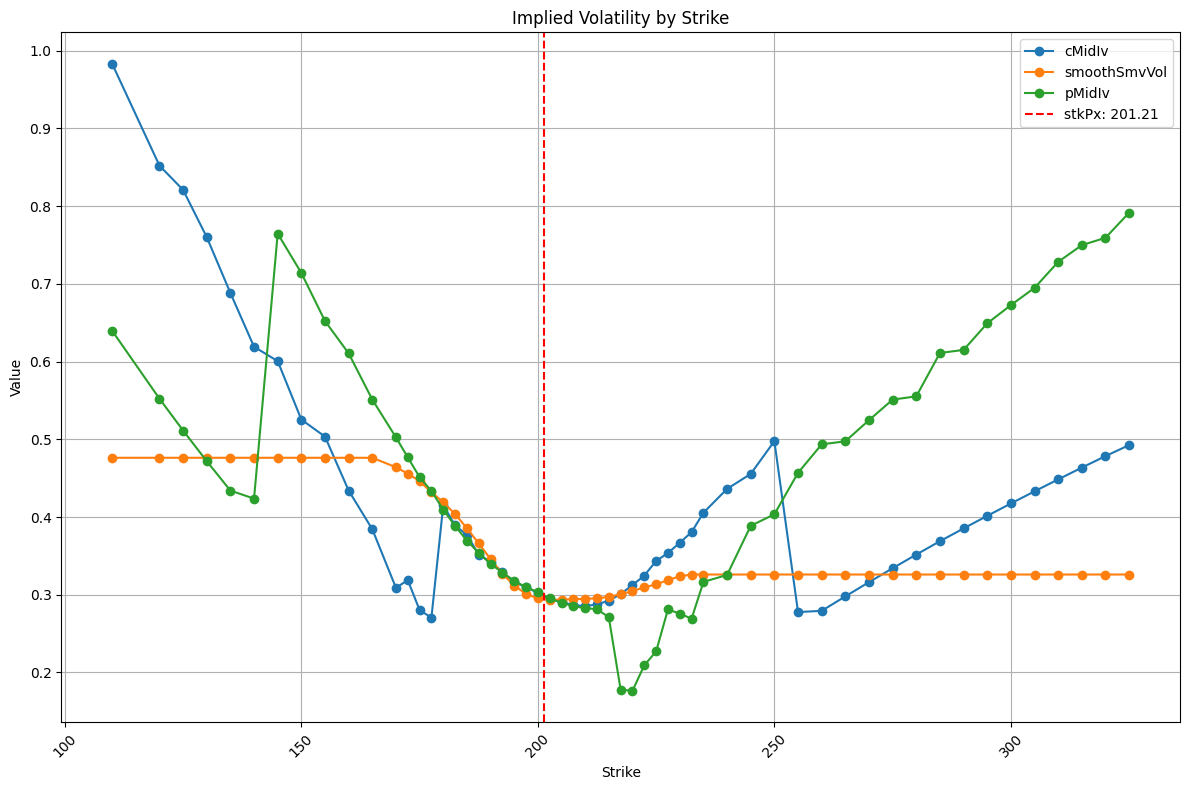

In [111]:
# Example usage (assuming your DataFrame is named filtered_data)
ticker = 'AAPL'
plot_iv_vol_by_strike(filtered_data.query(f"ticker == '{ticker}'"))

In [112]:
# Example usage (assuming your DataFrame is named filtered_data)
nearest_strikes_result = get_nearest_strikes_per_ticker(filtered_data)
nearest_strikes_expiry_result = get_nearest_strikes_per_ticker(base_df)

nearest_strikes_result.head()

,trade_date,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,distance
0,2025-05-28,AA,AA250606C00028000,AA250606P00028000,27.95,2025-06-06,0.02466,28.0,98,196,8,46,0.90,0.93,0.95,0.89,0.93,0.96,0.518438,0.53271,0.546989,0.528702,0.501270,0.52126,0.541249,0.0435,0,-0.002597,0.513429,0.172448,-0.053283,0.017523,0.003316,-0.003542,-0.051587,0.441248,0.764792,0.784889,0.0,0.05
1,2025-05-28,AA,AA250606C00027500,AA250606P00027500,27.95,2025-06-06,0.02466,27.5,2,55,2,15,1.18,1.21,1.25,0.67,0.70,0.73,0.529418,0.54984,0.570269,0.537151,0.511799,0.52934,0.546887,0.0435,0,-0.002597,0.598017,0.164757,-0.052834,0.017144,0.003831,-0.004126,-0.050874,0.448911,1.044392,0.564347,0.0,0.45
2,2025-05-28,AAL,AAL250606C00011500,AAL250606P00011500,11.46,2025-06-06,0.02466,11.5,2412,1405,402,638,0.33,0.33,0.34,0.36,0.36,0.37,0.477289,0.48424,0.491197,0.491528,0.479666,0.48662,0.493578,0.0435,0,-0.000464,0.502988,0.452462,-0.020320,0.007200,0.001339,-0.001423,-0.019667,0.435216,0.299743,0.328047,0.0,0.04
3,2025-05-28,AAL,AAL250606C00011000,AAL250606P00011000,11.46,2025-06-06,0.02466,11.0,159,986,800,2012,0.62,0.64,0.65,0.16,0.17,0.17,0.471658,0.49661,0.521570,0.513100,0.491067,0.49938,0.507691,0.0435,0,-0.000464,0.713142,0.370228,-0.018443,0.006023,0.001858,-0.002017,-0.017536,0.461638,0.613982,0.142312,0.0,0.46
4,2025-05-28,AAOI,AAOI250606C00017500,AAOI250606P00017500,17.66,2025-06-06,0.02466,17.5,0,11,0,20,1.20,1.25,1.30,1.00,1.07,1.10,1.001893,1.04749,1.093085,1.065330,0.989927,1.03552,1.081109,0.0435,0,-0.022236,0.558761,0.133989,-0.066526,0.010975,0.002122,-0.002436,-0.064978,1.004478,1.202836,1.015961,0.0,0.16


In [113]:
nearest_strikes_expiry_result.head()

,trade_date,ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,distance
0,2025-05-28,GLD,GLD250528C00304000,GLD250528P00304000,303.67,2025-05-28,0.0,304.0,4254,902,3342,1098,0.08,0.10,0.10,0.42,0.46,0.51,0.152789,0.16138,0.169971,0.160824,0.120408,0.16021,0.200013,0.0435,0,1.124836,0.260237,0.577565,-0.089275,0.011702,0.000095,-0.000095,-1.857118,0.161698,0.090298,0.464138,0.00,0.33
1,2025-05-28,GLD,GLD250528C00303000,GLD250528P00303000,303.67,2025-05-28,0.0,303.0,1354,366,3463,919,0.65,0.69,0.76,0.03,0.05,0.06,0.000000,0.12476,0.249529,0.170154,0.147971,0.16654,0.185118,0.0435,0,1.124836,0.883527,0.436059,-0.047009,0.006505,0.000154,-0.000154,-1.133301,0.171079,0.689089,0.047745,0.00,0.67
2,2025-05-28,IWM,IWM250528C00206000,IWM250528P00206000,205.74,2025-05-28,0.0,206.0,19681,1797,27441,3976,0.08,0.09,0.10,0.32,0.33,0.35,0.182172,0.19400,0.205832,0.193990,0.175822,0.19398,0.212132,0.0435,0,-0.585452,0.302312,0.749456,-0.090002,0.008462,0.000085,-0.000085,-1.635359,0.194085,0.090082,0.334963,0.00,0.26
3,2025-05-28,IWM,IWM250528C00205000,IWM250528P00205000,205.74,2025-05-28,0.0,205.0,2431,1113,18450,1868,0.75,0.80,0.81,0.02,0.03,0.03,0.000000,0.14800,0.296004,0.276689,0.225451,0.23799,0.250523,0.0435,0,-0.585452,0.873447,0.312662,-0.042289,0.004836,0.000245,-0.000246,-1.387940,0.276824,0.799898,0.042354,0.00,0.74
4,2025-05-28,NDX,NDX250528C21360000,NDX250528P21360000,21357.40,2025-05-28,0.0,21360.0,18,23,242,9,17.80,18.55,19.30,20.20,21.09,22.00,0.190691,0.19821,0.205732,0.194858,0.189317,0.19834,0.207365,0.0435,0,0.029942,0.479686,0.008211,-18.215494,0.997345,0.014009,-0.014034,-194.796600,0.172201,15.955831,18.492910,21361.58,2.60


In [114]:
# Example usage (assuming your DataFrame is named filtered_data)
ticker = 'AAPL' 
weighted_avg_result = calculate_weighted_average_columns_per_ticker(nearest_strikes_expiry_result.query(f"ticker == '{ticker}'"))

c:\Users\roryg\OneDrive\Desktop\infra\notebooks\helper\option_helpers.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[expir_date_column] = pd.to_datetime(df[expir_date_column])


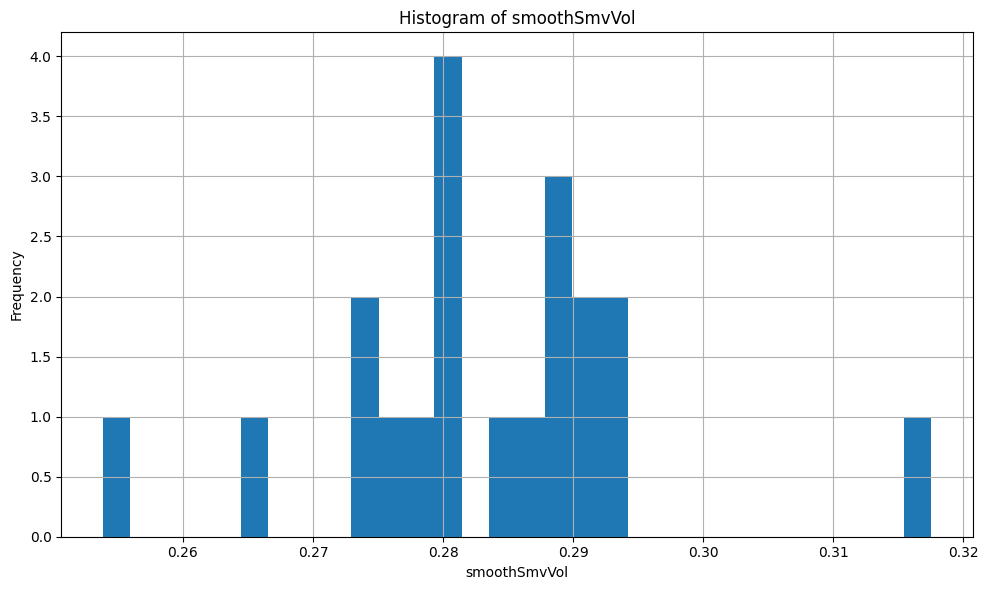

In [101]:
# Example usage (assuming your DataFrame is named spy_base_df)
plot_histogram(weighted_avg_result, 'smoothSmvVol');
# plot_histogram(spy_base_df, 'stkPx')

In [115]:

# Example Usage:
create_plot_interface(weighted_avg_result[['yte', 'cBidIv',
       'cMidIv', 'cAskIv', 'smoothSmvVol', 'pBidIv', 'pMidIv', 'pAskIv',
       'iRate', 'divRate', 'residualRateData', 'extVol']].copy()) # Use a copy to avoid unintended modifications

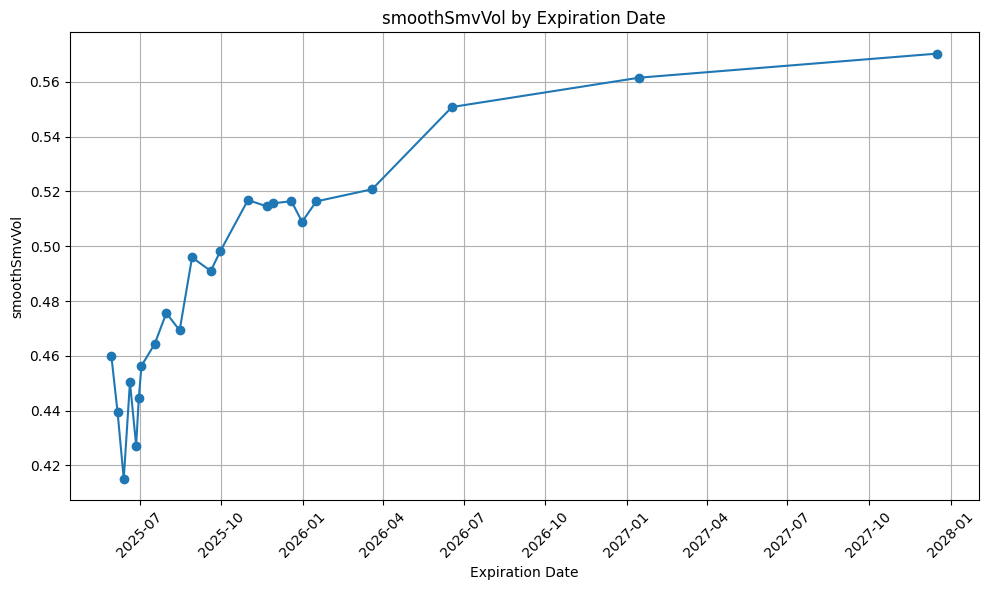

In [124]:
ticker = "IBIT"
check = nearest_strikes_expiry_result.query(f"ticker == '{ticker}'")[["expirDate", "smoothSmvVol"]].groupby("expirDate").mean().reset_index()
plot_column_by_expir_date(check, 'smoothSmvVol')


In [117]:
# Example Usage:
# create_interactive_ticker_plot(nearest_strikes_expiry_result);

In [125]:
# Assuming you have a DataFrame named 'option_data' with columns 'ticker', 'expirDate', 'yte', and 'cMidIv'
# option_data['ns_fit'] = 0 # Initialize the ns_fit column
check = nearest_strikes_expiry_result[['ticker', 'expirDate', "yte", 'smoothSmvVol', 'extVol']].groupby(["ticker", "expirDate"]).mean().reset_index()
ns_fitted_data = nelson_siegel_fit(check.query(f"ticker == '{ticker}'"), ticker_col='ticker', expir_date_col='expirDate', vol_col='smoothSmvVol', output_vol_col='ns_fit')
compared_vols_df = compare_vols_plot(ns_fitted_data) 
compared_vols_df_two = compare_vols_plot(ns_fitted_data, vol_col2='extVol',)

Volatility Comparison Statistics (Grouped by ticker and expirDate):

An unexpected error occurred: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.
Volatility Comparison Statistics (Grouped by ticker and expirDate):

An unexpected error occurred: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.


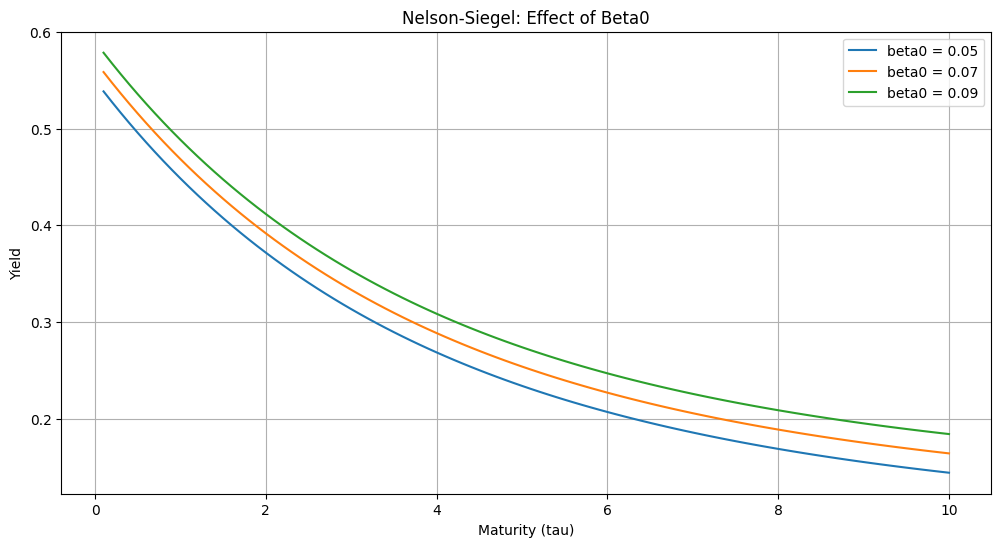

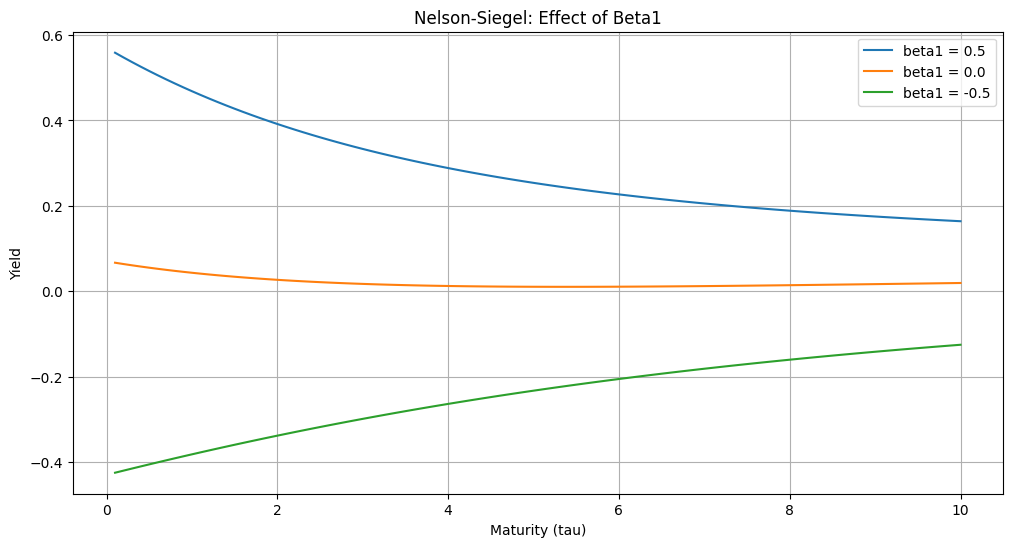

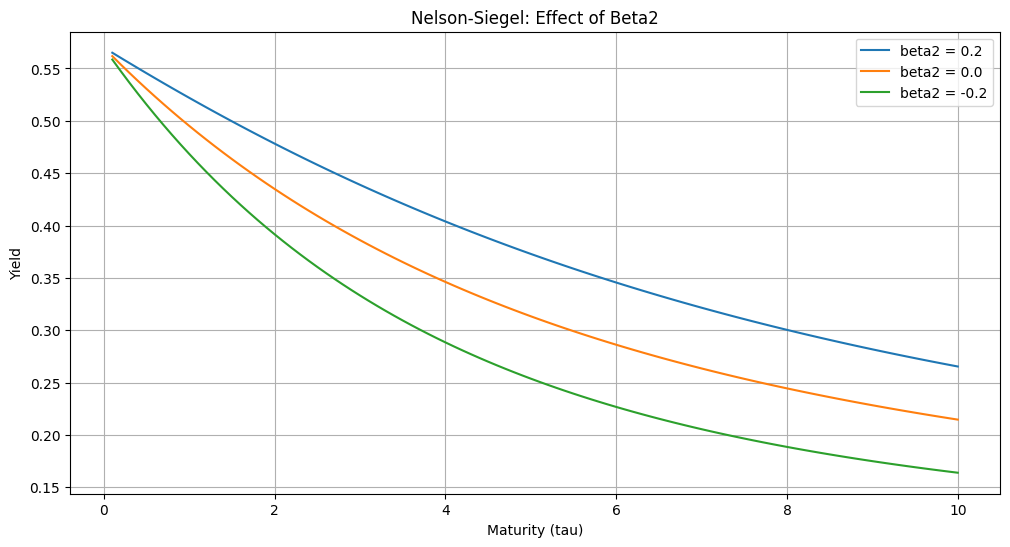

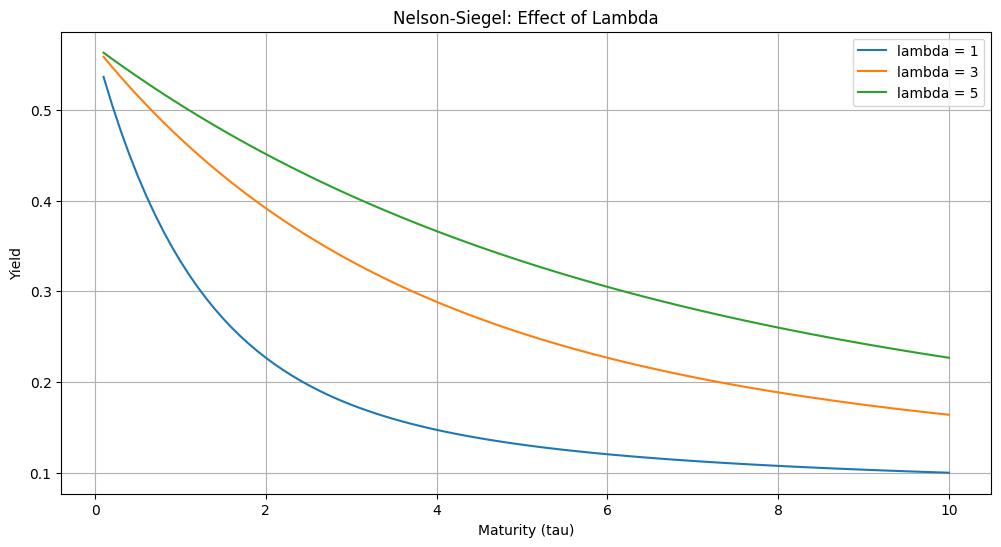

In [126]:
def nelson_siegel(tau, beta0, beta1, beta2, lamda):
    """Nelson-Siegel curve function."""
    return beta0 + beta1 * (1 - np.exp(-tau / lamda)) / (tau / lamda) + \
           beta2 * ((1 - np.exp(-tau / lamda)) / (tau / lamda) - np.exp(-tau / lamda))

# Define maturities (tau)
tau = np.linspace(0.1, 10, 100)  # Maturities from 0.1 to 10 years

# --- Effect of Beta0 (Long-Term Level) ---
plt.figure(figsize=(12, 6))
beta1, beta2, lamda = 0.5, -0.2, 3  # Keep other parameters constant

plt.plot(tau, nelson_siegel(tau, 0.05, beta1, beta2, lamda), label='beta0 = 0.05')
plt.plot(tau, nelson_siegel(tau, 0.07, beta1, beta2, lamda), label='beta0 = 0.07')
plt.plot(tau, nelson_siegel(tau, 0.09, beta1, beta2, lamda), label='beta0 = 0.09')
plt.title('Nelson-Siegel: Effect of Beta0')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Beta1 (Short-Term Level/Slope) ---
plt.figure(figsize=(12, 6))
beta0, beta2, lamda = 0.07, -0.2, 3

plt.plot(tau, nelson_siegel(tau, beta0, 0.5, beta2, lamda), label='beta1 = 0.5')
plt.plot(tau, nelson_siegel(tau, beta0, 0.0, beta2, lamda), label='beta1 = 0.0')
plt.plot(tau, nelson_siegel(tau, beta0, -0.5, beta2, lamda), label='beta1 = -0.5')
plt.title('Nelson-Siegel: Effect of Beta1')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Beta2 (Curvature) ---
plt.figure(figsize=(12, 6))
beta0, beta1, lamda = 0.07, 0.5, 3

plt.plot(tau, nelson_siegel(tau, beta0, beta1, 0.2, lamda), label='beta2 = 0.2')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, 0.0, lamda), label='beta2 = 0.0')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, -0.2, lamda), label='beta2 = -0.2')
plt.title('Nelson-Siegel: Effect of Beta2')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# --- Effect of Lambda (Curvature Shift) ---
plt.figure(figsize=(12, 6))
beta0, beta1, beta2 = 0.07, 0.5, -0.2

plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 1), label='lambda = 1')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 3), label='lambda = 3')
plt.plot(tau, nelson_siegel(tau, beta0, beta1, beta2, 5), label='lambda = 5')
plt.title('Nelson-Siegel: Effect of Lambda')
plt.xlabel('Maturity (tau)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

In [151]:
weighted_avg_expir_result = calculate_weighted_average_columns_per_ticker(filter_df_by_matching_tickers(nearest_strikes_expiry_result, pd.DataFrame.from_dict({"ticker": ["MSTR", "IBIT"]})))

In [153]:
merged_df = pd.merge(all_earnings_df, weighted_avg_expir_result, on="ticker",how='left')
merged_df["dte"] = merged_df["yte"] * 365
merged_df["wte"] = merged_df["yte"] * 52
all_wavg_df = weighted_avg_expir_result[["ticker", "expirDate",  "extVol", "smoothSmvVol", "yte", "pMidIv", "cMidIv",  "delta", "gamma", "vega", "theta", "rho"]]
parsed_earns_df = merged_df[["ticker", "expirDate",  "extVol", "smoothSmvVol", "yte", "pMidIv", "cMidIv", "exErnIv10d", "exErnIv20d", "exErnIv30d", "impErnMv", "impliedEarningsMove", "wksNextErn", "nextErnTod", "daysToNextErn", "dte", "wte", "ernMnth", "delta", "gamma", "vega", "theta", "rho", "tradeDate"]]
parsed_earns_df["pMidIv"] = parsed_earns_df["pMidIv"] 
parsed_earns_df["cMidIv"] = parsed_earns_df["cMidIv"] 

C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\129292692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_earns_df["pMidIv"] = parsed_earns_df["pMidIv"]
C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\129292692.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_earns_df["cMidIv"] = parsed_earns_df["cMidIv"]


In [154]:
ticker = "AAPL"
all_wavg_df.query(f"ticker == '{ticker}'")

,ticker,expirDate,extVol,smoothSmvVol,yte,pMidIv,cMidIv,delta,gamma,vega,theta,rho


C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\726207246.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["forwardVol"] = df["forwardVol"].fillna(df[vol_col_short])


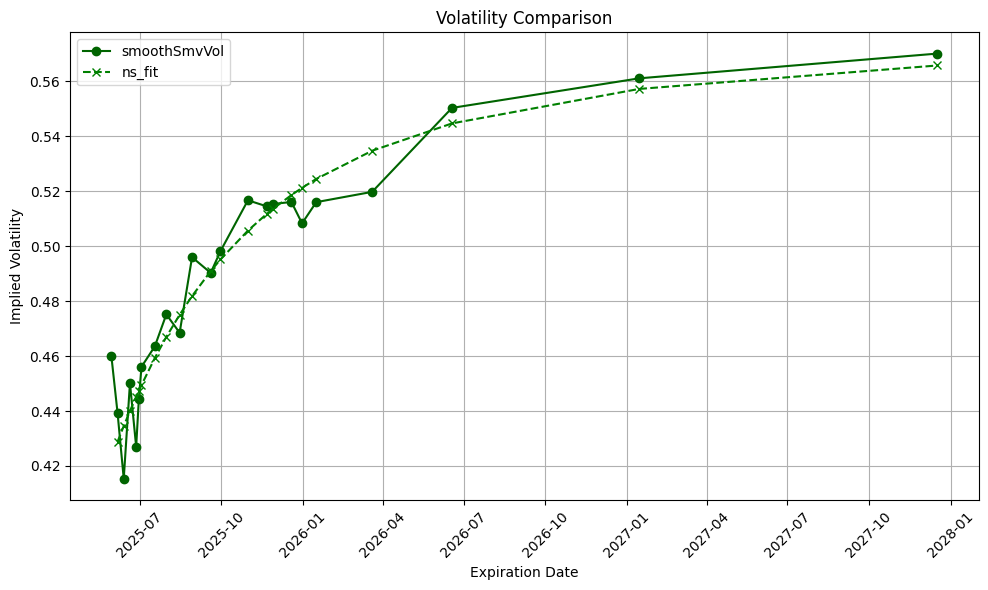

In [186]:
ticker = "IBIT"
option_data_df = all_wavg_df.query(f"ticker == '{ticker}'")
ns_fitted_data = nelson_siegel_fit(option_data_df.query(f"ticker == '{ticker}'"), ticker_col='ticker', vol_col='smoothSmvVol', dte_fit_cutoff=6/365)
# Calculate forward volatility by shifting 'smthSmvVol' by 1 row
option_data_df = calculate_forward_volatility_shifted_with_expir(option_data_df.copy(), shift_period=1)

# merge the forward volatility and ns fit data onto the original DataFrame
option_data_df = pd.merge(option_data_df, ns_fitted_data[['ticker', 'expirDate', 'ns_fit']], on=['ticker', 'expirDate'], how='left')

# Plot the regular and forward volatilities

plot_volatilities(option_data_df, regular_vol_col='smoothSmvVol', second_vol_col='ns_fit', third_vol_col=None)



In [187]:

event_data = {
    'date': ['2025-06-15', '2025-07-20', '2025-08-25', '2025-09-30', '2025-10-05'],
    'ticker': ['IBIT', 'IBIT', 'IBIT', 'IBIT', 'IBIT'],
    'event_comment': ['Product Launch', 'Earnings Release', 'Analyst Rating Change', 'Federal Reserve Meeting', 'Competitor Announcement'],
    'implied_move': [np.random.uniform(2, 10), np.random.uniform(2, 10), np.random.uniform(2, 10), np.random.uniform(2, 10), np.random.uniform(2, 10)]
}

event_df = pd.DataFrame(event_data)

# Convert 'date' column to datetime objects
event_df['date'] = pd.to_datetime(event_df['date'])



In [266]:
def calculate_cumulative_event_variance(event_df, options_data_df, ticker_expir_dates_df):
    """
    Calculates the cumulative event variance per ticker per expiry date, optimized with groupby and rolling sum.

    Args:
        event_df (pd.DataFrame): DataFrame with event data (date, event_comment, implied_move, ticker).
        options_data_df (pd.DataFrame): DataFrame with options data (expirDate, ticker, etc.).
        ticker_expir_dates_df (pd.DataFrame): DataFrame with 'ticker' and 'expirDate' columns
                                               specifying the expiry dates to calculate for each ticker.

    Returns:
        pd.DataFrame: DataFrame with cumulative event variance per ticker per expiry.
    """

    # Ensure datetime types
    event_df['date'] = pd.to_datetime(event_df['date'])
    options_data_df['expirDate'] = pd.to_datetime(options_data_df['expirDate'])
    ticker_expir_dates_df['expirDate'] = pd.to_datetime(ticker_expir_dates_df['expirDate'])

    # Filter event_df to include only relevant tickers
    tickers = options_data_df['ticker'].unique()
    event_df = event_df[event_df['ticker'].isin(tickers)].copy()

    # Calculate event variance
    event_df['event_variance'] = (event_df['implied_move'] / 100) ** 2

    # Create a list to hold the merged data for each ticker
    merged_data = []

    # Iterate through each ticker
    for ticker in ticker_expir_dates_df['ticker'].unique():
        # Get the expiry dates for the current ticker
        ticker_expir_dates = ticker_expir_dates_df[ticker_expir_dates_df['ticker'] == ticker][['expirDate']]

        # Get the events for the current ticker
        ticker_events = event_df[event_df['ticker'] == ticker].copy()

        # Perform a cross join to get all combinations of events and expiry dates for the ticker
        ticker_expir_dates['key'] = 1
        ticker_events['key'] = 1
        merged_ticker_df = pd.merge(ticker_expir_dates, ticker_events, on='key').drop("key", axis=1)

        # Filter to include only events that occurred on or before the expiry date
        merged_ticker_df = merged_ticker_df[merged_ticker_df['date'] <= merged_ticker_df['expirDate']]

        # Append the merged data to the list
        merged_data.append(merged_ticker_df)

    # Concatenate the merged data for all tickers
    merged_df = pd.concat(merged_data)

    # Calculate cumulative variance using groupby and rolling sum
    merged_df['cumulative_event_variance'] = merged_df.groupby(['ticker', 'expirDate'])['event_variance'].cumsum().fillna(method='ffill')

    # Select relevant columns and drop duplicates
    cumulative_variance_df = merged_df[['ticker', 'expirDate', 'cumulative_event_variance']].groupby(['ticker', 'expirDate']).max().drop_duplicates()

    return cumulative_variance_df


In [267]:
# Example Usage:
event_data = {
    'date': ['2025-06-15', '2025-07-20', '2025-08-25', '2025-09-30', '2025-10-05'],
    'ticker': ['IBIT', 'IBIT', 'IBIT', 'IBIT', 'IBIT'],
    'event_comment': ['Product Launch', 'Earnings Release', 'Analyst Rating Change', 'Federal Reserve Meeting', 'Competitor Announcement'],
    'implied_move': [2, 3, 1, 4, 2]
}

event_df = pd.DataFrame(event_data)
event_df['date'] = pd.to_datetime(event_df['date'])

ticker_expir_dates_df = option_data_df.query("ticker == 'IBIT'")[['ticker', 'expirDate']].drop_duplicates()
ticker_expir_dates_df['expirDate'] = pd.to_datetime(ticker_expir_dates_df['expirDate'])

cumulative_variance_result = calculate_cumulative_event_variance(event_df, option_data_df, ticker_expir_dates_df)
cumulative_variance_result


C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\1971787918.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['cumulative_event_variance'] = merged_df.groupby(['ticker', 'expirDate'])['event_variance'].cumsum().fillna(method='ffill')


cumulative_event_variance
ticker expirDate                            
IBIT   2025-06-20                     0.0004
       2025-07-31                     0.0013
       2025-08-29                     0.0014
       2025-09-30                     0.0030
       2025-10-31                     0.0034

In [303]:
def plot_volatilities(df, regular_vol_col='smoothSmvVol', second_vol_col='forwardVol', third_vol_col='forwardVol', fourth_vol_col=None, title='Volatility Comparison'):
    plt.figure(figsize=(10, 6))
    plt.plot(df['expirDate'], df[regular_vol_col], marker='o', linestyle='-', label=regular_vol_col, color='darkgreen')
    plt.plot(df['expirDate'], df[second_vol_col], marker='x', linestyle='--', label=second_vol_col, color='green')
    if third_vol_col in df.columns:
        plt.plot(df['expirDate'], df[third_vol_col], marker='h', linestyle=':', label=third_vol_col, color='black')
    if fourth_vol_col in df.columns:
        plt.plot(df['expirDate'], df[fourth_vol_col], marker='s', linestyle='-.', label=fourth_vol_col, color='gray')
        
    plt.xlabel('Expiration Date')
    plt.ylabel('Implied Volatility')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(df['expirDate'], rotation=90)  # Set tick marks to every expiry date
    plt.tight_layout()
    plt.show()

C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\1971787918.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['cumulative_event_variance'] = merged_df.groupby(['ticker', 'expirDate'])['event_variance'].cumsum().fillna(method='ffill')
C:\Users\roryg\AppData\Local\Temp\ipykernel_182608\2315328884.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df = pd.merge(option_data_df, cumulative_variance_result, on=['ticker', 'expirDate'], how='left').fillna(method="ffill").fillna(0)


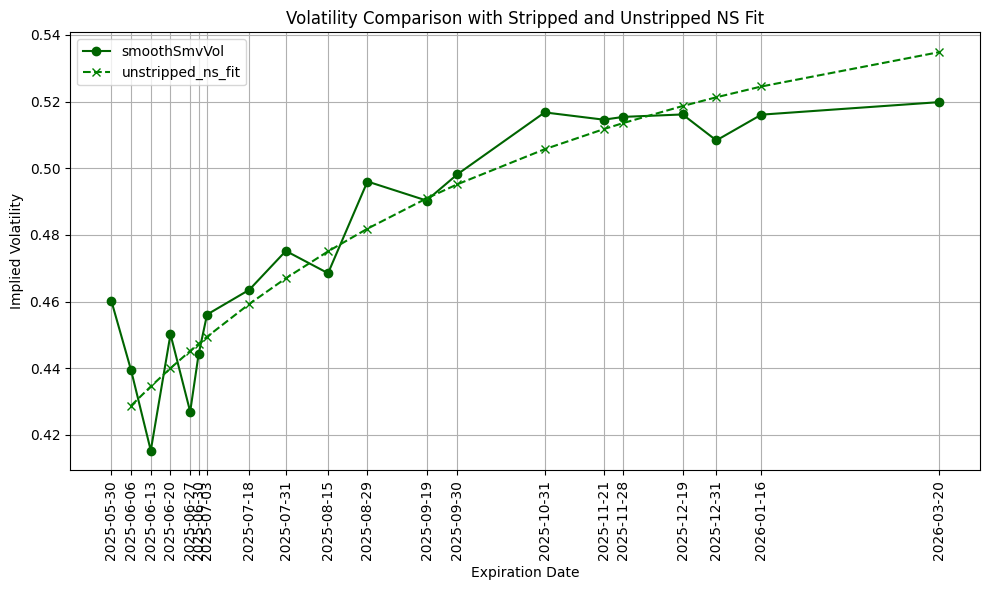

In [ ]:
event_df = pd.read_csv("data/IBIT_events.csv")
event_df['date'] = pd.to_datetime(event_df['date'])
ticker_expir_dates_df = option_data_df.query("ticker == 'IBIT'")[['ticker', 'expirDate']].drop_duplicates()
ticker_expir_dates_df['expirDate'] = pd.to_datetime(ticker_expir_dates_df['expirDate'])
cumulative_variance_result = calculate_cumulative_event_variance(event_df, option_data_df, ticker_expir_dates_df)
merged_df = pd.merge(option_data_df, cumulative_variance_result, on=['ticker', 'expirDate'], how='left').fillna(method="ffill").fillna(0)
merged_df['smoothSmvVar'] = (merged_df['smoothSmvVol'] ** 2) * merged_df["yte"]
merged_df['strippedSmoothSmvVar'] = merged_df['smoothSmvVar'] - merged_df['cumulative_event_variance']
merged_df['strippedSmvVol'] = np.sqrt(merged_df['strippedSmoothSmvVar'] / merged_df["yte"]) 
result_df = merged_df[['ticker', 'expirDate', "yte", 'smoothSmvVol', 'smoothSmvVar', 'cumulative_event_variance', 'strippedSmoothSmvVar', 'strippedSmvVol']]

ns_raw_fitted_data = nelson_siegel_fit(result_df, ticker_col='ticker', vol_col='smoothSmvVol', dte_fit_cutoff=6/365)
ns_raw_fitted_data["unstripped_ns_fit"] = ns_raw_fitted_data['ns_fit']
ns_fitted_data = nelson_siegel_fit(result_df, ticker_col='ticker', vol_col='strippedSmvVol', dte_fit_cutoff=6/365)
all_result_df = pd.merge(result_df, ns_fitted_data[['ticker', 'expirDate', 'ns_fit']], on=['ticker', 'expirDate'], how='left')
all_result_df = pd.merge(all_result_df, ns_raw_fitted_data[['ticker', 'expirDate', 'unstripped_ns_fit']], on=['ticker', 'expirDate'], how='left')
plot_volatilities(all_result_df.query("yte < 1"), regular_vol_col='smoothSmvVol', second_vol_col='unstripped_ns_fit', third_vol_col="strippedSmvVol", fourth_vol_col='ns_fit', title='Volatility Comparison with Stripped and Unstripped NS Fit')

In [307]:
event_df

,date,ticker,event_comment,implied_move
0,2025-06-11,IBIT,US CPI (May) Higher-than-expected CPI â†’ IBIT...,1.5
1,2025-06-17,IBIT,FOMC Meeting Policy decision; dovish = IBIT â†...,2.0
2,2025-06-18,IBIT,SEC In-Kind ETF Rulings Approval = more effici...,3.5
3,2025-06-27,IBIT,US PCE (May) Fed's preferred inflation metric,1.0
4,2025-06-30,IBIT,Stablecoin Legislation Vote Clarity = IBIT â†‘...,3.0
5,2025-07-03,IBIT,US Nonfarm Payrolls (June) Strong jobs = IBIT ...,1.5
6,2025-07-15,IBIT,US CPI (June),3.0
7,2025-07-28,IBIT,Tesla Q2 Earnings BTC on balance sheet; beat =...,3.0
8,2025-07-29,IBIT,FOMC Meeting Market reaction to Fed projections,2.5
9,2025-07-31,IBIT,US PCE (June),2.5


In [290]:
all_result_df

,ticker,expirDate,yte,smoothSmvVol,smoothSmvVar,cumulative_event_variance,strippedSmoothSmvVar,strippedSmvVol,ns_fit
0,IBIT,2025-05-30,0.00548,0.460183,0.001160,0.000000,0.001160,0.460183,NaN
1,IBIT,2025-06-06,0.02466,0.439400,0.004761,0.000000,0.004761,0.439400,0.407463
2,IBIT,2025-06-13,0.04384,0.415311,0.007562,0.000450,0.007112,0.402764,0.411443
3,IBIT,2025-06-20,0.06301,0.450191,0.012770,0.002075,0.010695,0.411996,0.415336
4,IBIT,2025-06-27,0.08219,0.426976,0.014984,0.002175,0.012809,0.394773,0.419145
5,IBIT,2025-06-30,0.09041,0.444206,0.017840,0.002400,0.015440,0.413248,0.420753
6,IBIT,2025-07-03,0.09863,0.456106,0.020518,0.002625,0.017893,0.425932,0.422345
7,IBIT,2025-07-18,0.13973,0.463524,0.030022,0.003525,0.026497,0.435462,0.430086
8,IBIT,2025-07-31,0.17534,0.475182,0.039591,0.005675,0.033916,0.439809,0.436503
9,IBIT,2025-08-15,0.21644,0.468499,0.047507,0.008450,0.039057,0.424795,0.443587


In [ ]:
# ...existing code...
def plot_volatilities(df, regular_vol_col='smoothSmvVol', second_vol_col='forwardVol', third_vol_col='forwardVol', fourth_vol_col=None, title='Volatility Comparison'):
    plt.figure(figsize=(10, 6))
    plt.plot(df['expirDate'], df[regular_vol_col], marker='o', linestyle='-', label=regular_vol_col, color='darkgreen')
    plt.plot(df['expirDate'], df[second_vol_col], marker='x', linestyle='--', label=second_vol_col, color='green')
    if third_vol_col in df.columns:
        plt.plot(df['expirDate'], df[third_vol_col], marker='h', linestyle=':', label=third_vol_col, color='black')
    if fourth_vol_col in df.columns:
        plt.plot(df['expirDate'], df[fourth_vol_col], marker='s', linestyle='-.', label=fourth_vol_col, color='gray')
        
    plt.xlabel('Expiration Date')
    plt.ylabel('Implied Volatility')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(df['expirDate'], rotation=45)  # Set tick marks to every expiry date
    plt.tight_layout()
    plt.show()
# ...existing code...

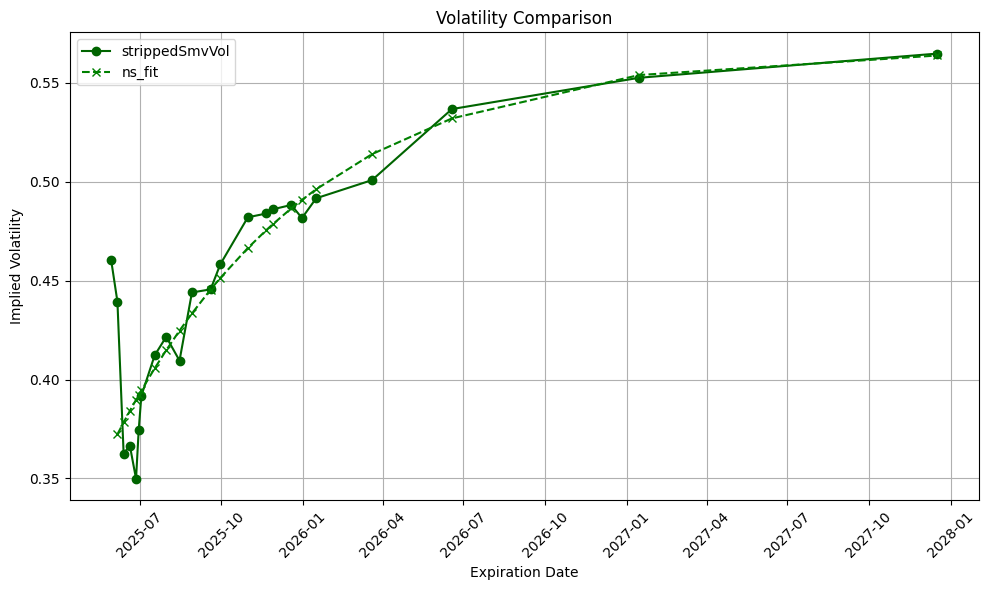

In [284]:
plot_volatilities(all_result_df, regular_vol_col='strippedSmvVol', second_vol_col="ns_fit", third_vol_col=None)

In [274]:
# all_earnings_with_date_df = all_earnings_df.merge(earnings_df, on="ticker", how="left")

In [273]:
# implied_move = 9.5 # in pct
# second_move = 3.6 # in pct
# stripped_front_earns_df = option_data_df[["ticker", "expirDate",  "smoothSmvVol", "yte", "impliedEarningsMove", "wksNextErn"]].merge(earnings_df, on="ticker", how="left")
# stripped_front_earns_df["impliedEarningsMove"] = implied_move
# stripped_front_earns_df["impliedSecondMove"] = second_move

# stripped_front_earns_df["smoothSmvVar"] = (stripped_front_earns_df["smoothSmvVol"] ** 2) * stripped_front_earns_df["yte"]
# stripped_front_earns_df["impliedEarningsMove"] = stripped_front_earns_df["impliedEarningsMove"] / 100
# stripped_front_earns_df["impliedEarningsMove"] = stripped_front_earns_df["impliedEarningsMove"].astype(float)
# stripped_front_earns_df["impliedSecondMove"] = stripped_front_earns_df["impliedSecondMove"] / 100
# stripped_front_earns_df["impliedSecondMove"] = stripped_front_earns_df["impliedSecondMove"].astype(float)

# stripped_front_earns_df["earnsVar"] = stripped_front_earns_df["impliedEarningsMove"] ** 2
# stripped_front_earns_df["earnsVar"] = np.where(stripped_front_earns_df['earnDate'] <= stripped_front_earns_df['expirDate'], stripped_front_earns_df["earnsVar"], 0)
# stripped_front_earns_df["remainderVar"] = stripped_front_earns_df["impliedSecondMove"] ** 2
# stripped_front_earns_df["remainderVar"] = np.where(stripped_front_earns_df['expirDate'][2] <= stripped_front_earns_df['expirDate'], stripped_front_earns_df["remainderVar"], 0)


# stripped_front_earns_df["frntStrpVar"] = stripped_front_earns_df["smoothSmvVar"] - stripped_front_earns_df["earnsVar"] 
# stripped_front_earns_df["totalStrpVar"] = stripped_front_earns_df["smoothSmvVar"] - stripped_front_earns_df["earnsVar"] - stripped_front_earns_df["remainderVar"] 

# stripped_front_earns_df["Front Earnings Stripped Vol"] = np.sqrt(stripped_front_earns_df["frntStrpVar"]/stripped_front_earns_df["yte"])
# stripped_front_earns_df["All Events Stripped Vol"] = np.sqrt(stripped_front_earns_df["totalStrpVar"]/stripped_front_earns_df["yte"])
# stripped_front_earns_df["Unstripped Smooth Vol"] = stripped_front_earns_df["smoothSmvVol"]
# stripped_front_earns_df.loc[3, "All Events Stripped Vol"] = 0.319
# plot_volatilities(stripped_front_earns_df,  regular_vol_col='Unstripped Smooth Vol', second_vol_col='Front Earnings Stripped Vol', third_vol_col="All Events Stripped Vol", title="Front Earnings Stripped Volatility vs Unstripped Volatility")